## **Setup**

In [1]:
!pip install scikit-learn-extra
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from functools import partial
from itertools import permutations
from sklearn import cluster, mixture, datasets as ds
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import load_iris
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import accuracy_score as accuracy 

In [0]:
# chcemy deterministyczne zachowanie do testów
random_state = 42
np.random.seed(random_state)
# ładniejsze rysunki
matplotlib.rc('axes', labelsize=15)
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

## **Metody**

Wszystkie metody z opisami wykorzystywane w tutorialu są zdefiniowane w tej sekcji. \
Kolory przekazywane są pomocą argumentu "cmap", lista dostępnych kolorów jest dostępna [tutaj](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html).

In [0]:
# Rysuje klaster punktów
def plot_clusters(X, y, title=None, xlabel=None, ylabel=None, size=1):
  plt.title(title)
  if xlabel:
    plt.xlabel(xlabel)
  if ylabel:
    plt.ylabel(ylabel)  
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=size, marker=".")

# Rysuje wiersz klastrów punktów (opcjonalnie bez koloru)
def plot_clusters_row(datasets, colors=True):
  plt.figure(figsize=(len(datasets)*5, 4))
  for index, (dataset_name, (X, y)) in enumerate(datasets.items()):
    plt.subplot(1, len(datasets), index+1)
    plot_clusters(X, y=y if colors else "k", title=dataset_name)

# Rysuje centrum klastru
def plot_centroids(centroids):
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=20, linewidths=8, color='w', zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=40, linewidths=50,color='r', zorder=11, alpha=1)

# Rysuje granice decyzyjne (opcjonalnie bez centrum)
def plot_decision_boundaries(cluster_model, X, with_centroids=True, plot_name=None):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], num=1000),
                         np.linspace(mins[1], maxs[1], num=1000))
    Z = cluster_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap='Spectral') 
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_clusters(X, y="k")
    if with_centroids:
        plot_centroids(cluster_model.cluster_centers_)
    if plot_name:
      plt.title(plot_name)

# W poniższych metodach plot_decision_boundaries możemy wykonać tylko na klasyfikatorze, który posiada metode "predict". Jeżeli nie posiada używamy plot_clusters.

# Klasyfikacja kmeans i rysowanie granicy decyzyjnej
def fit_kmeans(dataset, k, plot_name="kmeans"):
  kmeans = KMeans(n_clusters=k, random_state=random_state)
  y_pred = kmeans.fit_predict(dataset)
  if plot_name:
    plot_decision_boundaries(kmeans, dataset, plot_name=plot_name)
  return y_pred

# Klasyfikacja PAM i rysowanie granicy decyzyjnej
def fit_pam(dataset, k, plot_name="PAM"):
  pam = KMedoids(n_clusters=k, random_state=random_state)
  y_pred = pam.fit_predict(dataset)
  if plot_name:
    plot_decision_boundaries(pam, dataset, plot_name=plot_name)
  return y_pred

# Klasyfikacja aglomeracyjnego klastrowania hierarchinczego i rysowanie predykcji
def fit_ahc(dataset, k, plot_name="AgglomerativeClustering"):
  ahc = AgglomerativeClustering(n_clusters=k, linkage='single')
  y_pred = ahc.fit_predict(dataset)
  if plot_name:
    plot_clusters(dataset, y_pred, title=plot_name)
  return y_pred


# Rysuje przebieg działania pierwszych iteracji kmeans z losowym wyborem centroidów początkowych
def run_kmeans(dataset, k=3, iterations=3):
  assert 0 < iterations < 7, "Iteracje tylko dla przedziału 1-6"
  plt.figure(figsize=(5*iterations, 4))
  kmeans_iterations = [KMeans(n_clusters=k, init="random", n_init=1, algorithm="full", max_iter=i+1, random_state=random_state+2) for i in range(iterations)]
  for index, kmean_model in enumerate(kmeans_iterations):
    plt.subplot(1, iterations, index+1)
    kmean_model.fit(dataset)
    plot_decision_boundaries(kmean_model, dataset, plot_name=f"iteration_{index+1}")

# Zwraca najlepsze accuracy sprawdzając wszystkie permutacje
def find_best_accuracy(pred, y):
  return max(accuracy(pred, y_perm) for y_perm in (list(map(lambda x: mapping[x], y)) for mapping in permutations(set(y))))

# Zwraca accuracy i rysuje predykcje dla wszystkich zbiorów w datasets 
def run_benchmark(datasets, algorithms): # algorithms - lista callable, przymujących tylko 1 argument - dataset
  assert len(datasets) == len(algorithms), "Liczba datasetów powinen mieć być równa liczbie algorytmów"
  plt.figure(figsize=(5*len(datasets), 4))
  for index, (dataset_name, (X, y)) in enumerate(datasets.items()):
    plt.subplot(1, len(datasets), index+1)
    updated_title = f"{dataset_name}\n{algorithms[index].keywords['plot_name']if 'plot_name' in algorithms[index].keywords else ''}" 
    pred = algorithms[index](X, plot_name=updated_title)
    print(f"{updated_title}\n"
          f"accuracy {100*find_best_accuracy(pred, y):.2f}%\n"
          f"{'-' * 50}\n")

## **Dataset**


Dataset został rozbity na 2 części, podstawowy na podstawie modułu [clustering](https://scikit-learn.org/stable/modules/clustering). \
Drugi dobrze znany z poprzednich zajęć [iris](https://archive.ics.uci.edu/ml/datasets/iris) tylko na potrzeby zadania.

### **Podstawowy**

In [0]:
# Tworzymy customowe klastry, w celu pokazania działania algorytmów
n_samples = 1500
noisy_circles = ds.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = ds.make_moons(n_samples=n_samples, noise=.05)
blobs = ds.make_blobs(n_samples=n_samples, random_state=random_state)
no_structure = np.random.rand(n_samples, 2), np.zeros(n_samples, dtype=np.int)

X, y = ds.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
varied = ds.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

datasets = {"Pierścienie": noisy_circles,
            "Księżyce": noisy_moons,
            "Rożne-wariancje": varied,
            "Niesymetryczne": aniso,
            "Plamy": blobs,
            "Bez-struktury": no_structure}

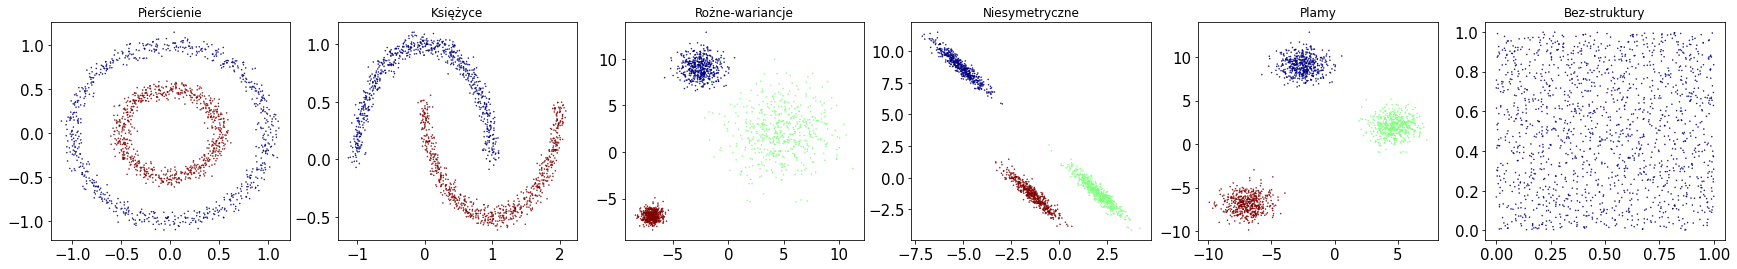

In [5]:
plot_clusters_row(datasets)

W Clusteringu **nie** używany etykiet do treningu, poniżej wizualizacja danych wejściowych które przyjmuje algorytm.

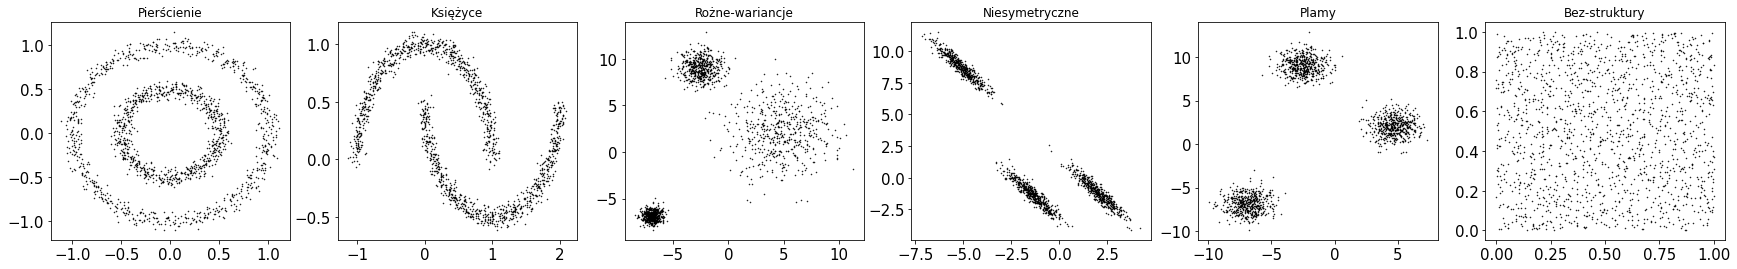

In [6]:
plot_clusters_row(datasets, colors=False)

### **Do zadania**

In [0]:
data = load_iris()
X, y = data.data[:,2:4], data.target # Używamy tylko 2 z 4 dostępnych cech do zadania

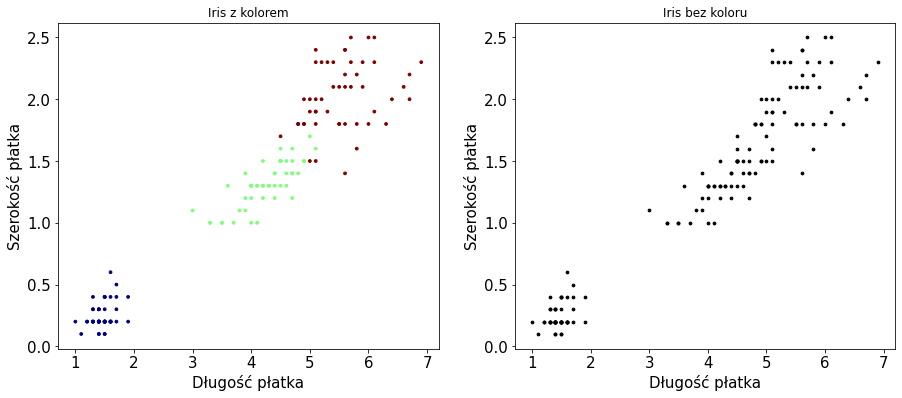

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plot_clusters(X,y, title="Iris z kolorem", xlabel="Długość płatka", ylabel="Szerokość płatka", size=30)
plt.subplot(1,2,2)
plot_clusters(X,y="k", title="Iris bez koloru", xlabel="Długość płatka", ylabel="Szerokość płatka", size=30)

Analizując dane nieetykietowane dla naszego zbioru nie jesteśmy w stanie stwierdzić, czy są tutaj 2 czy 3 klastry, algorytmy w których nie trzeba podawać liczby klastrów mogą sobie nie poradzić z podzieleniem "górnego" klastra na 2 osobne. W praktyce z takimi sytuacjami będziemy się spotkać przy realnych danych.

## **Clustering (analiza skupień)**

Zadaniem clusteringu jest pogrupowanie obserwacji zbioru w pewne klastry. \

**Przypadki użycia**:
- Analiza danych
 - Przy analizie danych możemy zebrać dane w klastry i szukać wzorców w każdym z osobna.
- Segmentacja (obrazu/rynku/clientów itp)
 - obrazu - grupowanie pixeli w klastry (np. żeby zastąpić pixele średnią danego klastru, tym samym zmniejszyć liczbę unikalnych kolorów na zdjęciu i skorzystać z kolejnych algorytmów np klasyfikacji)
 - rynku/klientów - możemy podzielić klientów na grupy które posiadają podobny gust i chętnie kupują te samy przedmioty
- Systemy do rekomendacji
 - Może korzystać z segmentacji rynku, systemy typu netflix/youtube wyświetlające spersonalizowane wyniki
- Wyszukiwarki
 - Załóżmy, że mamy zdjęcie samochodu A i chcemy znaleźć inne zdjęcia tego samochodu. Możemy pogrupować dane w klastry i zwrócić inne zdjęcia z klastra, w którym jest sachochód A jako wynik. (Zauważmy, że moglibyśmy tutaj użyć KNN, jednakaże w przypadku klastrów nie trzeba przeszukiwać bazy w poszukiwaniu zbliżonych zdjęć, gdyż klastry mamy już obliczone wcześniej) 
- Redukcja wymiarowości
 - Mając dane klastry możemy dla każdej obserwacji stworzyć wektor "podobieństwa" na podstawie pewnej metryki. Tym samym każda obserwacja nowego zbioru będzie k wymiarowym wektorem, gdzie k oznacza liczbę klastrów.  
- Detekcja anomalii
 - Mając dane klastry, obserwację, który są "oddalone" od wszystkich klastrów możemy uznać za anomalie. Możemy w ten sposób usunąć obserwacje odstające przed trenowaniem modelu.

**Uwaga** \
- Dane do clusteringu są **nieetykietowane**, w przeciwieństwie do klasyfikacji. \
-Clustering zazwyczaj jest używany do preprecessingu danych (np zamiast PCA), a dopiero później korzystamy z podstawowych algorytmów do klasyfikacji typu KNN, SVM etc. \
- W tym tutorialu użyjemy otrzymach klastrów do klasyfikacji (tzn będziemy badać metrykę accuracy), nie jest to do końca poprawne, gdyż nie wiemy który klaster odpowiada której etykiecie. \
- Są inne [metryki](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) do evaluacji, niektóre algorytmy posiadają swoję metryki (np kmeans posiada inertie, czyli średnią kwadratową odległości wszystkich punktów do ich najbliższego środka klastra)

### **K-means**

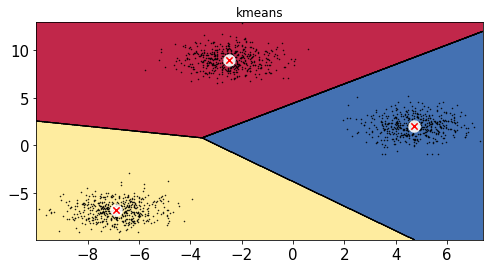

In [9]:
plt.figure(figsize=(8, 4))
X, _ = datasets['Plamy'] # jako input do modelu podajemy tylko dane treningowe, bez etykiet
fit_kmeans(X, k=3); # średnik zapobiega wyświetlaniu się ostatniej lini w komórce

- Jak działa ten algorytm?
- Skąd wzięliśmy liczbę klastrów?
- Dla jakich zbiorów wychodzą dobre wyniki?

**Działanie algorytmu** \
Załóżmy, że mamy daną **liczbę** klastrów k oraz etykiety dla każdego zbioru. Jak znaleźć centrum klastra? Wystarczy policzyć średnią w każdym zbiorze. \
Z racji tego, że tutaj nie mamy etykiet, natomiast mamy liczbę klastrów możemy stworzyć następujący algorytm:

1.  Wybierz losowo k centrów klastrów.
2.  Dla każdego punktu przydziel mu etykietę "najbliższego" klastra. (względem pewnej metryki, najcześciej $L2$).
3.  Jako nowy środek klastra przyjmuj średnią wartość punktów z jego zbioru.
4. Powtarzaj 2-3, aż do zbieżności (istnieje dowód, że ta zajdzie w skończonym czasie, i to zazwyczaj szybko).

**Zalety**
- Łatwy do zrozumienia i zaimplementowania
- Szybki (nie mamy dużo obliczeń i zazwyczaj szybko zbiega)

**Wady**
- Nie działa dla każdych danych (np. księżyce, elipsoidy, pierścienie o tym samym środku i różnym promieniu)
- Wymaga infomracji o liczbie klastrów a priori.
- Brak spójności między wywołaniami (centra startowe są wybierane losowe)

**W praktyce**
- są algorytmy do znajdowania k
- są odmiany algorytmu przyśpieszające obliczenia (wersje accelerated/mini-batch)  
- algorytm odpala się kilka razy aby uniknąć problemu ze spójnością
- inicjalizacja centrum wcale nie jest randomowa (algorytm k-means++ / domyślna dla kmeans w sklearn nie jest, trzeba to wymusić)

Poniżej przykład kolejnych 4 iteracji algorytmu dla przykładu z początku podrozdziału. 

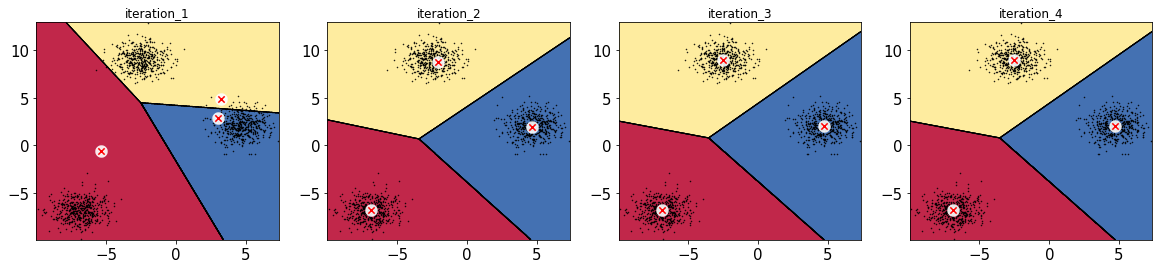

In [10]:
run_kmeans(X, k=3, iterations=4) # wymuszona inicjalizacja losowa  

Jak widać nawet z losową inicjalizacją mamy szybką zbieżność, ale nie zawsze optymalną (można sprawdzić zmieniając random_state w metodzie run_kmeans).

Jak znaleźć k?
- Czasami znamy liczbę a priori (np. liczbę etykiet, liczbę kolorów które chcemy mieć na zdjęciu po segmentacji)
-[Hyperparameter search](https://scikit-learn.org/stable/modules/grid_search.html) (grid/random) 
- [Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), np [użycie](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
- Wybrać losowo (dla dużych zbiorów danych relatywnie mała róznica)

Plamy_2
Kmeans(k=2)
accuracy 66.67%
--------------------------------------------------

Plamy_3
Kmeans(k=3)
accuracy 100.00%
--------------------------------------------------

Plamy_4
Kmeans(k=4)
accuracy 83.60%
--------------------------------------------------

Plamy_5
Kmeans(k=5)
accuracy 66.33%
--------------------------------------------------

Plamy_6
Kmeans(k=6)
accuracy 52.73%
--------------------------------------------------

Plamy_7
Kmeans(k=7)
accuracy 44.80%
--------------------------------------------------



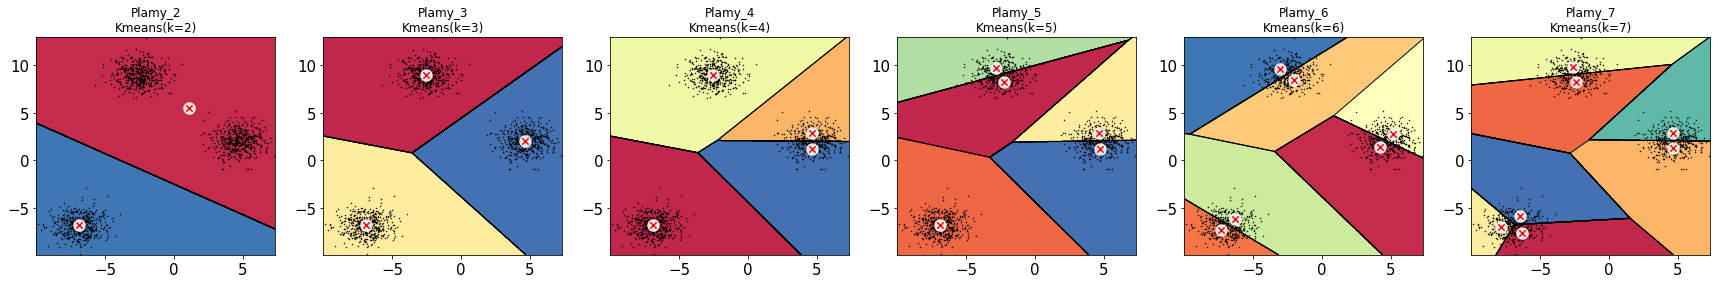

In [11]:
# Wizualizacja algorytmu dla różnych k i zbioru plam
ks = list(range(2, 8))
repeated_blobs =  {f"Plamy_{i}": datasets['Plamy'] for i in range(2,8)}
algorytms = [partial(fit_kmeans, k=k, plot_name=f"Kmeans(k={k})") for k in ks] # algorytm musi być callable z 1 argumentem `dataset`, musimy zrobić bind argumentów do funkcji
run_benchmark(repeated_blobs, algorytms)

Pierścienie
Kmeans(k=2)
accuracy 50.13%
--------------------------------------------------

Księżyce
Kmeans(k=2)
accuracy 75.13%
--------------------------------------------------

Rożne-wariancje
Kmeans(k=3)
accuracy 98.93%
--------------------------------------------------

Niesymetryczne
Kmeans(k=3)
accuracy 99.47%
--------------------------------------------------

Plamy
Kmeans(k=3)
accuracy 100.00%
--------------------------------------------------

Bez-struktury
Kmeans(k=4)
accuracy 24.73%
--------------------------------------------------



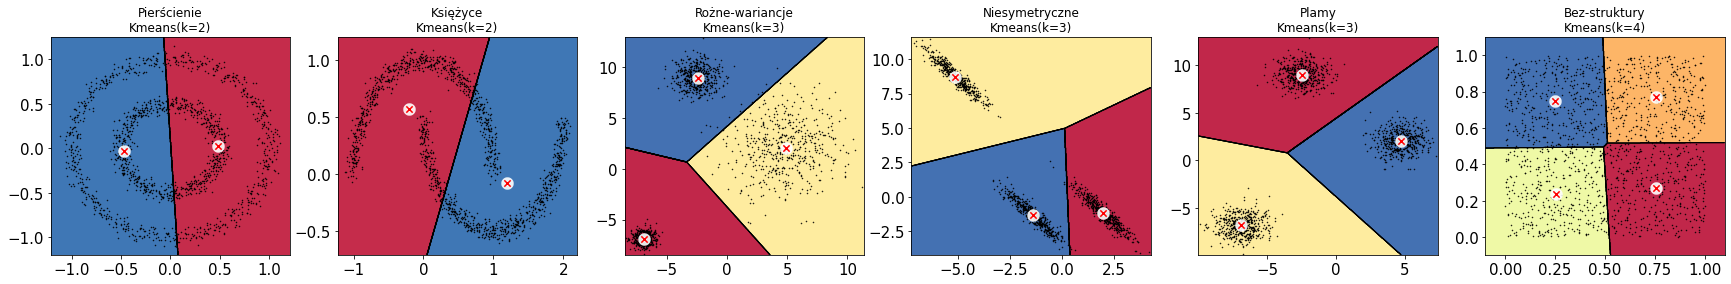

In [12]:
ks = [2, 2, 3, 3, 3, 4] # tutaj dobieramy k jako optymalnie i sprawdzimy jak sobie radzi nasz algorytm na różnych zbiorach
algorytms = [partial(fit_kmeans, k=k, plot_name=f"Kmeans(k={k})") for k in ks]
run_benchmark(datasets, algorytms) # datasets zdefiniowane wcześniej

**Wnioski** \
Gdy nie mamy do czynienia z centroidami, algorytm centroidów sobie nie poradzi. \
Dla pierścieni i księzycy dużo lepiej byłoby użyć algorytmu [dbscan](https://scikit-learn.org/stable/modules/clustering#dbscan), który dobiera klastry 'skanując' pobliskich sąsiadów.

### **k-medoids** (Partitioning around medoids, metoda grupowania wokół centroidów, PAM)

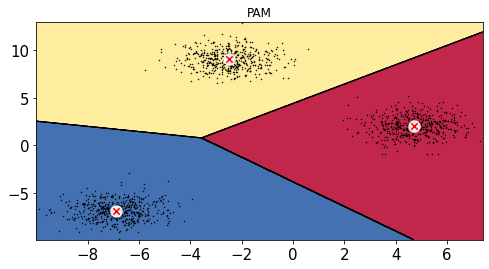

In [13]:
plt.figure(figsize=(8, 4))
X, _ = datasets['Plamy']
fit_pam(X, k=3);

**Działanie** \
Liczba klastrów k dana a priori.

1.   Wybierz k punktów jako medoidy (zachłannie) 
2.   Dla każdego niemedoidu przydziel mu etykietę "najbliższego" klastra (względem pewnej metryki, najcześciej $L2$)
3.   Iteracyjnie zastąp medoid niemedoidem i sprawdź czy odległość od najbliższych medoidów się poprawiła (inertia) 
4. Jeżeli w 3 nastąpiła zmiana powtórz 3, w przeciwnym przypadku zakończ

Jak widzimy, róznica między tym algorytmem a kmeans jest tylko w wyborze medoidow. W kmeans wybieraliśmy średnią w klastrze, tutaj zamiast centrów szukamy najlepszego punktu, który będzie najbardziej pasował na środek.


In [14]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/e/e1/K-Medoids_Clustering.gif')

**Cechy**
- Podobny do kmeans
- **Centrum jest obserwacją**, wyobraźmy sobie rozłączne i oddalone od siebie okręgi. Kmeans jako środek klastra wybierze środek koła, PAM niestety nie zadziała, gdyż musi wziąć pewien punkt z okręgu. (w praktyce ciężko o takie dane, zwłacza w wielu wymiarach) 
- Brak wsparcia w bibliotece sklearn

Rożne-wariancje2
PAM(k=2)
accuracy 66.67%
--------------------------------------------------

Rożne-wariancje3
PAM(k=3)
accuracy 99.07%
--------------------------------------------------

Rożne-wariancje4
PAM(k=4)
accuracy 81.87%
--------------------------------------------------

Rożne-wariancje5
PAM(k=5)
accuracy 44.33%
--------------------------------------------------

Rożne-wariancje6
PAM(k=6)
accuracy 43.93%
--------------------------------------------------

Rożne-wariancje7
PAM(k=7)
accuracy 40.00%
--------------------------------------------------



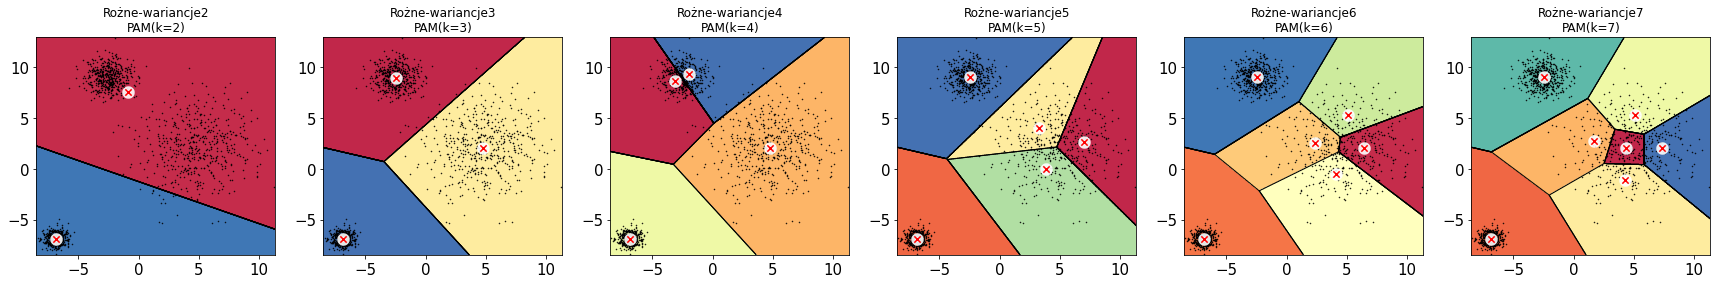

In [15]:
# Wizualizacja algorytmu dla różnych k i zbioru plam z różnymi wariancjami
ks = list(range(2, 8))
repeated_anisos =  {f"Rożne-wariancje{i}": datasets['Rożne-wariancje'] for i in range(2,8)}
algorytms = [partial(fit_pam, k=k, plot_name=f"PAM(k={k})") for k in ks]
run_benchmark(repeated_anisos, algorytms)

Pierścienie
PAM(k=2)
accuracy 50.33%
--------------------------------------------------

Księżyce
PAM(k=2)
accuracy 74.33%
--------------------------------------------------

Rożne-wariancje
PAM(k=3)
accuracy 99.07%
--------------------------------------------------

Niesymetryczne
PAM(k=3)
accuracy 99.47%
--------------------------------------------------

Plamy
PAM(k=3)
accuracy 100.00%
--------------------------------------------------

Bez-struktury
PAM(k=4)
accuracy 27.73%
--------------------------------------------------



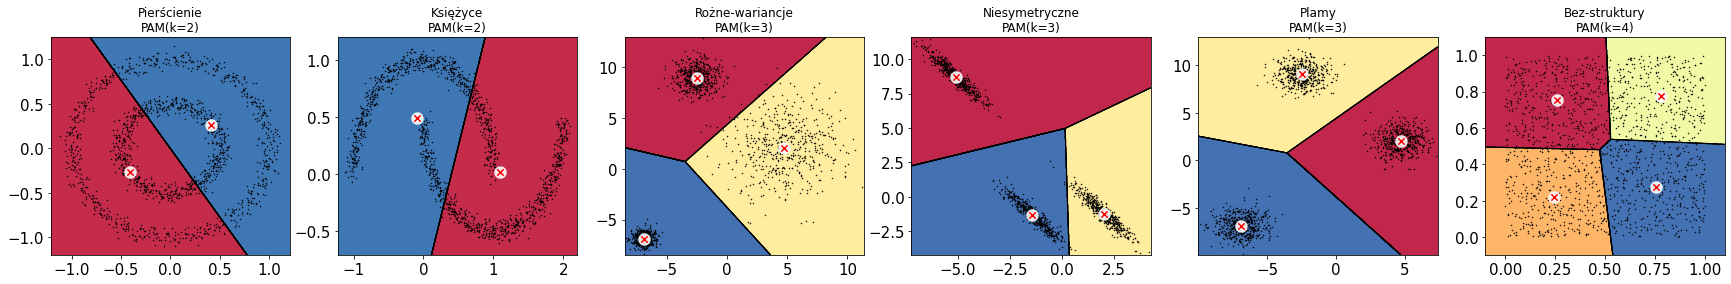

In [16]:
ks = [2, 2, 3, 3, 3, 4] # Ponownie optymalne k dla porównania z kmeans
algorytms = [partial(fit_pam, k=k, plot_name=f"PAM(k={k})") for k in ks]
run_benchmark(datasets, algorytms)

**Wnioski** \
Wyniki dla algorytmu PAM zazwyczaj pokrywają się z kmeans (o ile centrum klastra kmeans jest relatywnie blisko jakiegoś punktu) 

### **Agglomerative Hierarchical Clustering** (metoda aglomeracyjnego klastrowania hierarchicznego)

Istnieją 2 podejścia do hierarchicznego grupowania. \
Metody aglomeracyjne (bottom up) - każda obserwacja tworzy 1 klaster i grupujemy. (te nas interesują) \
Metody deglomeracyjne (top down) - wszystkie obserwacje tworzą 1 klaster i rozbijamy

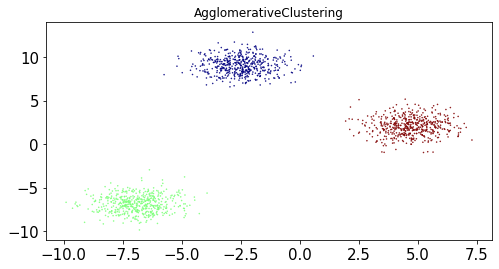

In [17]:
plt.figure(figsize=(8, 4))
X, _ = datasets['Plamy'] # nie tworzymy granicy decyzyjnej ze względu na brak metody predict dla tej klasy (można ją wygenerować poprzez np opakowanie clusteringu w KNN)
fit_ahc(X, k=3);

**Działanie**


1.   Policz odległość między wszystkimi parami punktów (względem pewnej metryki)
2.   Połącz 2 najbliższe punkty w zbiorze i traktuj jako 1
3.   Powtarzaj aż zostanie żądana liczba klastrów

Liczba klastrów k dana a priori.

In [18]:
# Źródło https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/
Image(url="https://cdn-images-1.medium.com/max/1600/1*ET8kCcPpr893vNZFs8j4xg.gif")

Księżyce2
AgglomerativeClustering(k=2)
accuracy 100.00%
--------------------------------------------------

Księżyce3
AgglomerativeClustering(k=3)
accuracy 99.93%
--------------------------------------------------

Księżyce4
AgglomerativeClustering(k=4)
accuracy 99.87%
--------------------------------------------------

Księżyce5
AgglomerativeClustering(k=5)
accuracy 99.73%
--------------------------------------------------

Księżyce6
AgglomerativeClustering(k=6)
accuracy 99.67%
--------------------------------------------------

Księżyce7
AgglomerativeClustering(k=7)
accuracy 99.60%
--------------------------------------------------



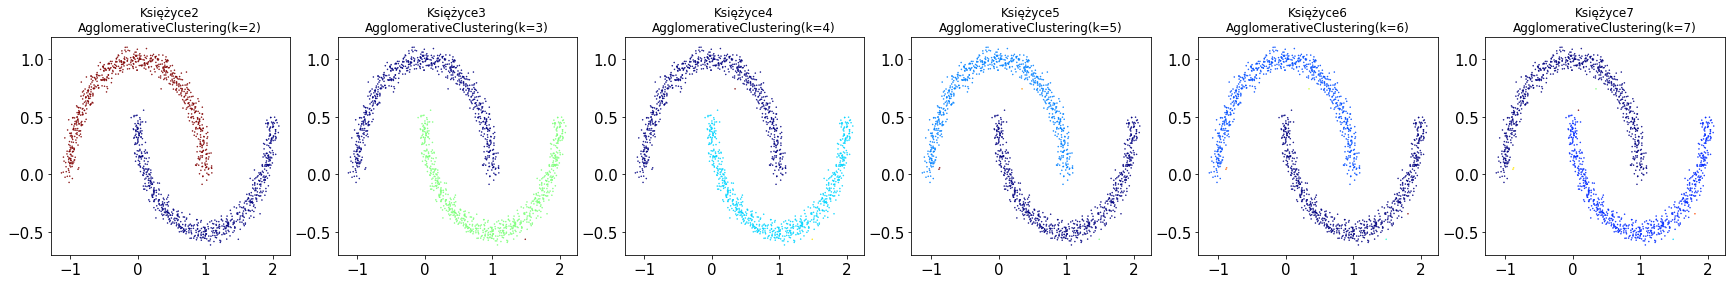

In [19]:
# Wizualizacja algorytmu dla różnych k i zbioru dwóch księżycy
ks = list(range(2, 8))
repeated_moons =  {f"Księżyce{i}": datasets['Księżyce'] for i in range(2,8)}
algorytms = [partial(fit_ahc, k=k, plot_name=f"AgglomerativeClustering(k={k})") for k in ks]
run_benchmark(repeated_moons, algorytms)

Pierścienie
AgglomerativeClustering(k=2)
accuracy 100.00%
--------------------------------------------------

Księżyce
AgglomerativeClustering(k=2)
accuracy 100.00%
--------------------------------------------------

Rożne-wariancje
AgglomerativeClustering(k=3)
accuracy 66.87%
--------------------------------------------------

Niesymetryczne
AgglomerativeClustering(k=3)
accuracy 100.00%
--------------------------------------------------

Plamy
AgglomerativeClustering(k=3)
accuracy 100.00%
--------------------------------------------------

Bez-struktury
AgglomerativeClustering(k=4)
accuracy 99.60%
--------------------------------------------------



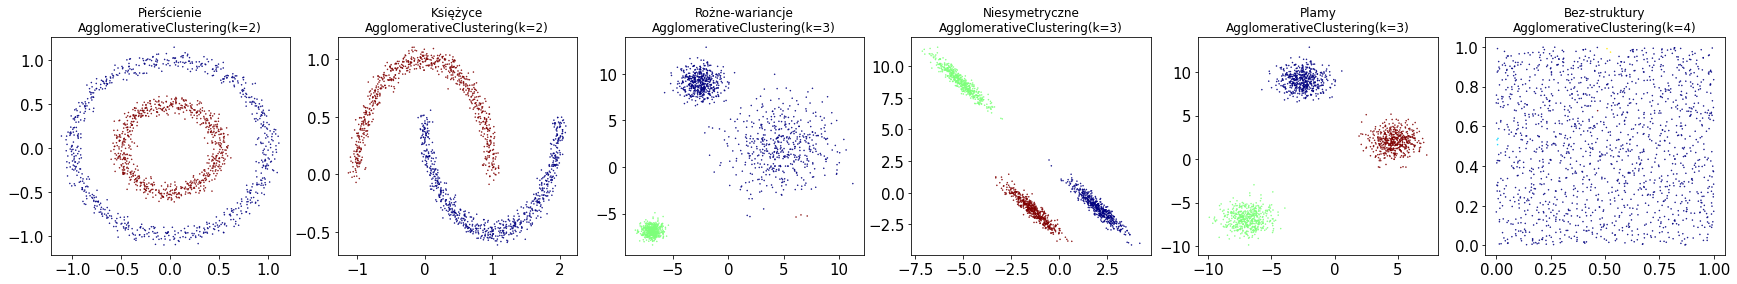

In [20]:
ks = [2, 2, 3, 3, 3, 4]
algorytms = [partial(fit_ahc, k=k, plot_name=f"AgglomerativeClustering(k={k})") for k in ks] # Nie możemy tutaj narysować granicy decyzyjnej, ze względu na brak metody predict dla klasyfikatora
run_benchmark(datasets, algorytms);

**Wnioski** \
Wyniki zależą od używanego parametru [linkage](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering), to znaczy na jakiej podstawie łączymy ze sobą punkty. \
Algorytm lepiej sobie radzi z nietypowymi strukturami danych, jednakżę może mieć problem przy różniących się wariancjach. (na co może pomóc dobór parametrów/użycie odpowiedniego skalowania danych) 


## **Zadanie**

Dla danych podstawowych zapoznaj się i przetestuj 2 nowe algorytmy
- [Dbscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
- [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift) \

Działanie tych algorytmów znajdziemy [tutaj](https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/).

Algorytmy powinny 
- wypisać accuracy dla wszystkich 6 zbiorów 
- narysować wykresy
- (tylko dla dbscan) zbadać na jednym wybranym zbiorze wpływ parametru eps na wynik \
Wykorzystane powinny zostać metody metody zdefiniowane w tutorialu.

In [0]:
from sklearn.cluster import DBSCAN, MeanShift

In [0]:
def fit_dbscan(dataset, eps, plot_name="DBSCAN"):
  pass # TODO

In [0]:
epsilons = None # TODO
#TOO dataset
algorytms = None # TODO
run_benchmark(None, algorytms) #TODO dataset

In [0]:
eps = None # TODO
algorytms = None #TODO
run_benchmark(datasets, algorytms);

In [0]:
def fit_meanshift(dataset, plot_name="MeanShift"): #TODO argumenty, można nie wybierać żadnego lub można użyć bandwidth/dowolny wybrany 
  pass # TODO

In [0]:
# TODO jeżeli argumenty
algorytms = None #TODO
run_benchmark(datasets, algorytms);

Dla nowych danych przestestuj 2 z 5 poznanych algorytmów. \
W przypadku algorytmu, który wymaga podania liczby klastrów wybieramy 3. \
Dla każdego algorytmu powinien być wykres oraz accuracy.

In [0]:
data = load_iris()
X, y = data.data[:,2:4], data.target # Używamy tylko 2 z 4 dostępnych cech do zadania

In [0]:
# TODO

## **Zadanie** (rozwiązanie)

Dla danych podstawowych zapoznaj się i przetestuj 2 nowe algorytmy
- [Dbscan](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
- [MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift) \

Działanie tych algorytmów znajdziemy [tutaj](https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/).

Algorytmy powinny 
- wypisać accuracy dla wszystkich 6 zbiorów 
- narysować wykresy
- (tylko dla dbscan) zbadać na jednym wybranym zbiorze wpływ parametru eps na wynik \
Wykorzystane powinny zostać metody metody zdefiniowane w tutorialu.

In [0]:
from sklearn.cluster import DBSCAN, MeanShift

In [0]:
def fit_dbscan(dataset, eps, plot_name="DBSCAN"):
  dbscan = DBSCAN(eps)
  y_pred = dbscan.fit_predict(dataset)
  if plot_name:
    plot_clusters(dataset, y_pred, title=plot_name)
  return y_pred

Rożne-wariancje2
DBSCAN(eps=0.1)
accuracy 21.87%
--------------------------------------------------

Rożne-wariancje3
DBSCAN(eps=0.2)
accuracy 51.27%
--------------------------------------------------

Rożne-wariancje4
DBSCAN(eps=0.3)
accuracy 61.13%
--------------------------------------------------

Rożne-wariancje5
DBSCAN(eps=0.4)
accuracy 38.73%
--------------------------------------------------

Rożne-wariancje6
DBSCAN(eps=0.5)
accuracy 86.87%
--------------------------------------------------

Rożne-wariancje7
DBSCAN(eps=0.6)
accuracy 89.93%
--------------------------------------------------



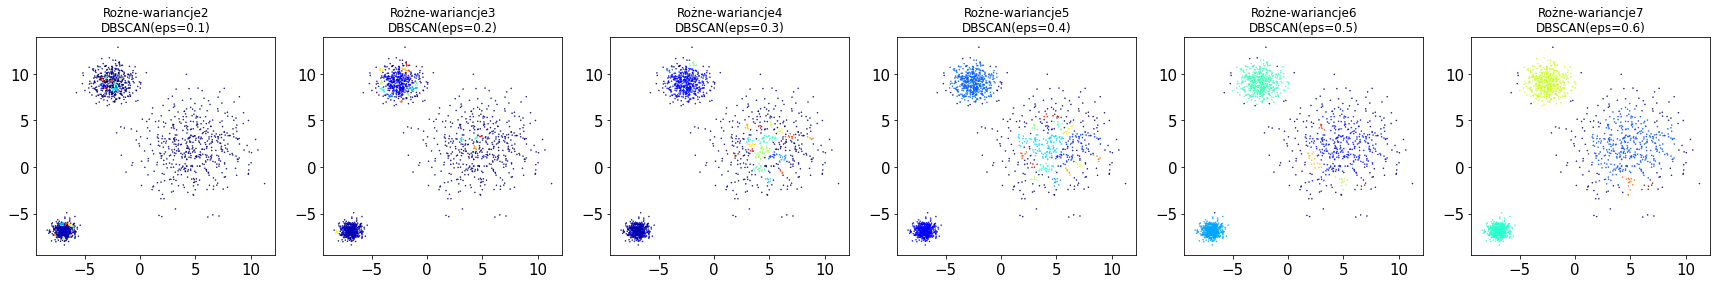

In [23]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
repeated_anisos =  {f"Rożne-wariancje{i}": datasets['Rożne-wariancje'] for i in range(2,8)}
algorytms = [partial(fit_dbscan, eps=eps, plot_name=f"DBSCAN(eps={eps})") for eps in epsilons]
run_benchmark(repeated_anisos, algorytms)

Pierścienie
DBSCAN(eps=0.2)
accuracy 100.00%
--------------------------------------------------

Księżyce
DBSCAN(eps=0.2)
accuracy 100.00%
--------------------------------------------------

Rożne-wariancje
DBSCAN(eps=1.0)
accuracy 98.00%
--------------------------------------------------

Niesymetryczne
DBSCAN(eps=0.5)
accuracy 99.47%
--------------------------------------------------

Plamy
DBSCAN(eps=0.5)
accuracy 96.67%
--------------------------------------------------

Bez-struktury
DBSCAN(eps=0.5)
accuracy 100.00%
--------------------------------------------------



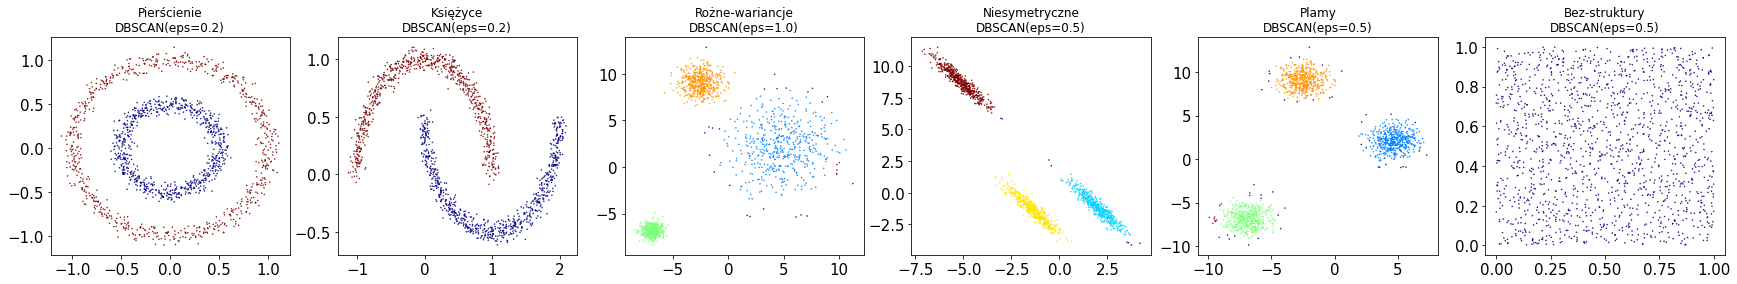

In [24]:
epsilons = [0.2, 0.2, 1., 0.5, 0.5, 0.5]
algorytms = [partial(fit_dbscan, eps=eps, plot_name=f"DBSCAN(eps={eps})") for eps in epsilons]
run_benchmark(datasets, algorytms);

In [0]:
def fit_meanshift(dataset, bandwidth, plot_name="MeanShift"):
  meanshift = MeanShift(bandwidth=bandwidth)
  y_pred = meanshift.fit_predict(dataset)
  if plot_name:
    plot_decision_boundaries(meanshift, dataset, plot_name=plot_name)
  return y_pred

Pierścienie
MeanShift(bandwidth=0.6)
accuracy 26.73%
--------------------------------------------------

Księżyce
MeanShift(bandwidth=0.3)
accuracy 12.13%
--------------------------------------------------

Rożne-wariancje
MeanShift(bandwidth=None)
accuracy 99.07%
--------------------------------------------------

Niesymetryczne
MeanShift(bandwidth=None)
accuracy 66.67%
--------------------------------------------------

Plamy
MeanShift(bandwidth=None)
accuracy 100.00%
--------------------------------------------------

Bez-struktury
MeanShift(bandwidth=0.3)
accuracy 30.53%
--------------------------------------------------



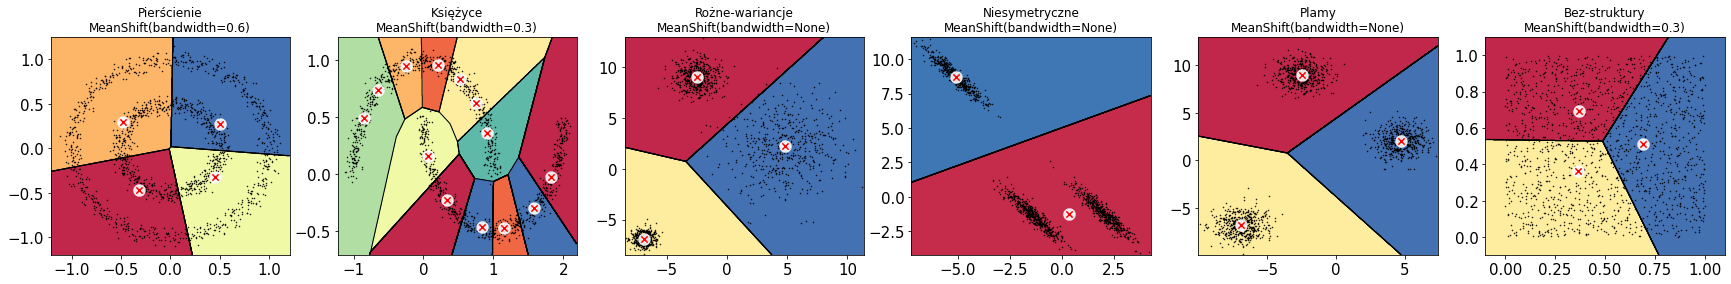

In [26]:
bandwidths = [0.6, 0.3, None, None, None, 0.3]
algorytms = [partial(fit_meanshift, bandwidth=bandwidth, plot_name=f"MeanShift(bandwidth={bandwidth})") for bandwidth in bandwidths]
run_benchmark(datasets, algorytms)

Dla nowych danych przestestuj przynajmniej 3 z 5 poznanych algorytmów. \
W przypadku algorytmu, który wymaga podania liczby klastrów wybieramy 3. \
Dla każdego algorytmu powinien być wykres oraz accuracy.

In [0]:
data = load_iris()
X, y = data.data[:,2:4], data.target # Używamy tylko 2 z 4 dostępnych cech do zadania

accuracy 96.00%



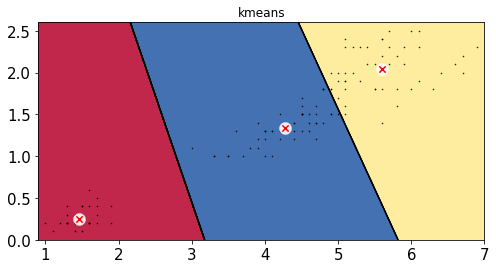

In [28]:
# Kmeans
plt.figure(figsize=(8, 4))
y_pred = fit_kmeans(X, k=3);
print(f"accuracy {100*find_best_accuracy(y_pred, y):.2f}%\n")

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)


accuracy 94.67%



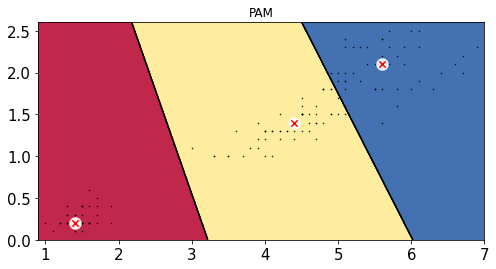

In [29]:
# Pam
plt.figure(figsize=(8, 4))
y_pred = fit_pam(X, k=3);
print(f"accuracy {100*find_best_accuracy(y_pred, y):.2f}%\n")

accuracy 96.00%



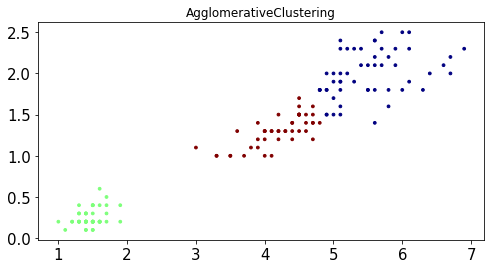

In [30]:
# Ahc
# Redefinicja tylko w celu zmiany rozmiaru punktów
def fit_ahc(dataset, k, plot_name="AgglomerativeClustering"):
  ahc = AgglomerativeClustering(n_clusters=k)
  y_pred = ahc.fit_predict(dataset)
  if plot_name:
    plot_clusters(dataset, y_pred, title=plot_name, size=30)
  return y_pred

plt.figure(figsize=(8, 4))
y_pred = fit_ahc(X, k=3);
print(f"accuracy {100*find_best_accuracy(y_pred, y):.2f}%\n")

accuracy 66.67%



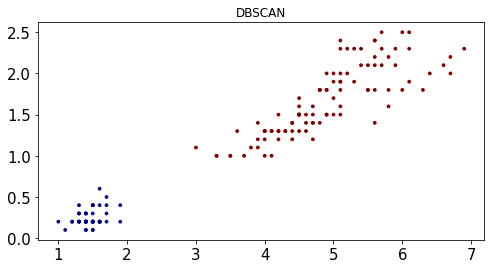

In [31]:
# Dbscan 
#pomimo dobrych wyników na podstawowych zbiorach danych, tutaj nie jest w stanie podzielić górnego klastra na 2
def fit_dbscan(dataset, eps, plot_name="DBSCAN"):
  dbscan = DBSCAN(eps)
  y_pred = dbscan.fit_predict(dataset)
  if plot_name:
    plot_clusters(dataset, y_pred, title=plot_name, size=30)
  return y_pred


plt.figure(figsize=(8, 4))
y_pred = fit_dbscan(X, eps=0.5);
print(f"accuracy {100*find_best_accuracy(y_pred, y):.2f}%\n")

accuracy 96.00%



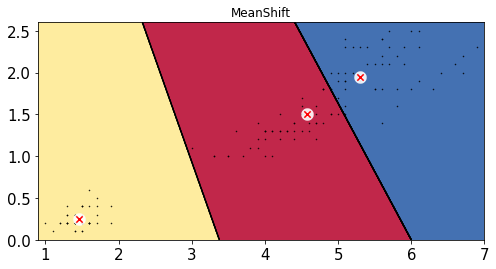

In [32]:
# Meanshift
plt.figure(figsize=(8, 4))
y_pred = fit_meanshift(X, bandwidth=None);
print(f"accuracy {100*find_best_accuracy(y_pred, y):.2f}%\n")